In [16]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import re 
from utils import * 
import os 
from src.ggkbase import * 
import glob
import matplotlib as mpl 
from src.files import BLASTFileJSON, FASTAFile, InterProScanFileTSV, GenBankFile, fasta_get_genome_size
import subprocess
import shutil
import networkx as nx
from matplotlib.colors import LinearSegmentedColormap, to_hex


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
cmap_blues = LinearSegmentedColormap.from_list('blues', ['lightblue', 'steelblue'])
cmap_grays = LinearSegmentedColormap.from_list('grays', ['lightgray', 'gray'])

def cmap_sample(cmap, n):
    return [to_hex(color) for color in cmap(np.linspace(0, 1, n))]

In [18]:

# Want to evaluate the likelihood of other potential hosts. Look for all other Methanoperedens in the bioreactors. 
# For some reason, it seems like things aren't appropriately-labeled in the coassembly. 
organism_info_df = list()
for path in glob.glob('../data/ggkbase/*organism_info.tsv'):
    organism_info_df.append(load_organism_info(path))
organism_info_df = pd.concat(organism_info_df)

mp_organism_info_df = organism_info_df[organism_info_df.taxonomy.str.contains('Methanoperedens') | organism_info_df.index.str.contains('Methanoperedens')].copy()
bb_organism_info_df = organism_info_df[organism_info_df.index.str.contains('Black_Borg')].copy()


In [19]:
def run_fastani(input_dir:str='../data/ggkbase/contigs', output_dir:str='../data/ggkbase'):
    input_list_path = os.path.join('.', 'fastani_input.txt')
    output_path = os.path.join(output_dir, 'fastani.tsv')
    input_paths = list(glob.glob(os.path.join(input_dir, '*')))
    with open(input_list_path, 'w') as f:
        f.write('\n'.join(input_paths))
    cmd = f'fastANI --ql {input_list_path} --rl {input_list_path} -o {output_path}'
    subprocess.run(cmd, shell=True, check=True)
    os.remove(input_list_path)
    
# run_fastani()

def load_fastani(path:str='../data/ggkbase/fastani.tsv'):
    cols = ['query_genome_path', 'ref_genome_path', 'ani', 'n_aligned', 'n_fragments']
    fastani_df = pd.read_csv(path, sep='\t', names=cols)
    fastani_df['query_genome_id'] = fastani_df.query_genome_path.apply(lambda path : os.path.basename(path).replace('.contigs.fa', ''))
    fastani_df['ref_genome_id'] = fastani_df.ref_genome_path.apply(lambda path : os.path.basename(path).replace('.contigs.fa', ''))
    return fastani_df

In [20]:
threshold = 99
mp_genome_ids = mp_organism_info_df.index.tolist()

fastani_df = load_fastani()
fastani_df = fastani_df[fastani_df.ani > threshold].copy()
fastani_df = fastani_df[fastani_df.query_genome_id.isin(mp_genome_ids) | fastani_df.ref_genome_id.isin(mp_genome_ids)].copy()

edges = list(zip(fastani_df.query_genome_id, fastani_df.ref_genome_id))
graph = nx.Graph(edges)
strains = list(nx.connected_components(graph))
print('Num. separate Methanoperedens strains:', len(strains))

strain_ids = {genome_id:f'mp_{i + 1}' for i, genome_ids in enumerate(strains) for genome_id in genome_ids}

mp_organism_info_df['strain_id'] = mp_organism_info_df.index.map(strain_ids)
# Use the biggest assembly as the representative. These are the ones used to create the id_to_ggkbase_name_map.
mp_organism_info_df = mp_organism_info_df.sort_values('bin_length', ascending=False).drop_duplicates('strain_id')
mp_organism_info_df = mp_organism_info_df.reset_index()

Num. separate Methanoperedens strains: 5


In [ ]:
# for id_, ggkbase_name in id_to_ggkbase_name_map.items():
#     subprocess.run(f'cp ../data/ggkbase/contigs/{ggkbase_name}.contigs.fa ../data/data/{id_}.fn', shell=True, check=True)
#     subprocess.run(f'cp ../data/ggkbase/genbank/{ggkbase_name}.gbk ../data/data/{id_}.gbk', check=True, shell=True)

# for id_, ggkbase_name in id_to_ggkbase_name_map.items():
#     gff_file = GenBankFile.from_file(f'../data/ggkbase/genbank/{ggkbase_name}.gbk')
#     gff_file.to_fasta(f'../data/data/{id_}.gff')

In [58]:
coverm_df = coverm_load('../data/coverm', contig_sizes=contig_sizes)
coverm_df['bioreactor'] = coverm_df.sample_id.str.match(r'ck_.*|n_.*')
coverm_df = coverm_df[coverm_df.bioreactor].copy()

def filter_low_abundance(coverm_df, min_rpkm:float=1, min_n_samples:int=1):
    include_target_names = coverm_df.groupby('target_name').apply(lambda df : (df.rpkm > min_rpkm).sum() > min_n_samples, include_groups=False)
    include_target_names = include_target_names[include_target_names].index 
    n_target_names = coverm_df.target_name.nunique()
    print(f'filter_low_abundance: Retaining {len(include_target_names)} out of {n_target_names} targets after filtering for abundance.')
    return coverm_df[coverm_df.target_name.isin(include_target_names)].copy()

In [60]:


def plot_abundance(figure_df:pd.DataFrame, title=r'$\it{Methanoperedens}$ abundance', min_rpkm=1e-2, legend:bool=False):
    sample_ids = figure_df.sample_id.unique()
    n_samples = figure_df.sample_id.nunique()

    figure_df = figure_df.sort_values(['sample_id', 'rpkm'])
    figure_df['year'] = [sample_id.split('_')[-1] for sample_id in figure_df.sample_id]
    figure_df = filter_low_abundance(figure_df, min_rpkm=min_rpkm)

    target_names = figure_df.target_name.unique()[::-1]
    palettes = dict()
    palettes['2024'] = dict(zip(target_names, cmap_sample(cmap_grays, len(target_names))))
    palettes['2025'] = dict(zip(target_names, cmap_sample(cmap_blues, len(target_names))))
    # print(palettes)

    # Want to visualize the coverage of each Methanoperedens strain in the bioreactors. 
    fig, ax = plt.subplots(figsize=(5, 3.5))
    bottom = np.zeros(n_samples)
    for target_name, df in figure_df.groupby('target_name'):
        colors = [palettes[year].get(target_name, 'red') for year in df.year]
        heights = df.rpkm.values
        ax.bar(x=np.arange(n_samples), height=heights, bottom=bottom, label=target_name, edgecolor='black', lw=0.7, color=colors)
        bottom += heights
    ax.set_title(title)
    ax.set_ylabel('RPKM')
    ax.set_xticks(np.arange(n_samples), labels=sample_ids, rotation=90)

    if legend:
        ax.legend()

    plt.show()


filter_low_abundance: Retaining 5 out of 5 targets after filtering for abundance.


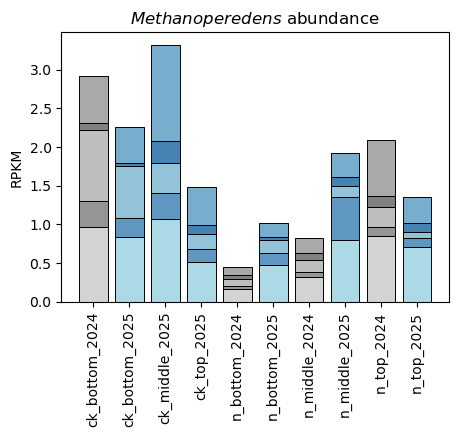

In [47]:
figure_df = coverm_df[coverm_df.target_name.str.startswith('mp_')].copy()
plot_abundance(figure_df)


filter_low_abundance: Retaining 4 out of 25 targets after filtering for abundance.


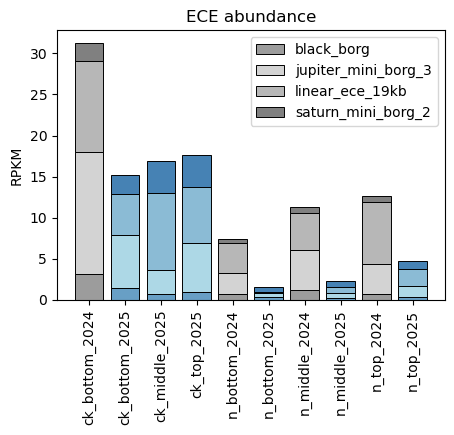

In [61]:
figure_df = coverm_df[~coverm_df.target_name.str.startswith('mp_')].copy() # Remove the Methanoperedens.
plot_abundance(figure_df, title='ECE abundance', min_rpkm=1, legend=True)

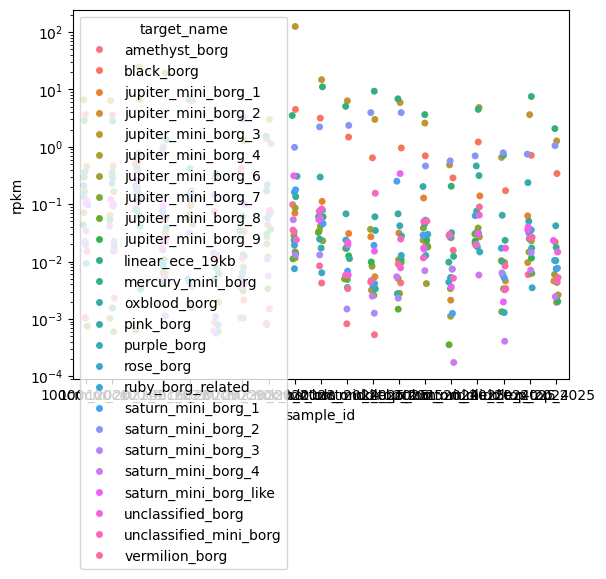

In [26]:
# Also want a way to show the decrease in ECE (all Borgs) abundance, but making it comparable across samples. 

fig, ax = plt.subplots()

figure_df = coverm_df[~coverm_df.target_name.str.startswith('mp_')].copy() # Remove the Methanoperedens.

sns.stripplot(figure_df, x='sample_id', y='rpkm', hue='target_name')
ax.set_yscale('log')
plt.show()

In [27]:
figure_df

,sample_id,target_name,variance,mean,trimmed_mean,read_count,genome_size,library_size,rpkm
0,100cm_2020,amethyst_borg,0.011476,0.007039,0.006224,49,49808,65413674,0.015039
1,100cm_2020,black_borg,62.429837,14.279516,14.275739,242239,1016609,65413674,3.642685
2,100cm_2020,jupiter_mini_borg_1,0.691728,0.354218,0.343345,2077,106442,65413674,0.298301
3,100cm_2020,jupiter_mini_borg_2,0.573821,0.237535,0.232728,3312,111561,65413674,0.453847
4,100cm_2020,jupiter_mini_borg_3,137.034254,34.553014,34.699240,22730,52742,65413674,6.588314
...,...,...,...,...,...,...,...,...,...
565,n_top_2025,saturn_mini_borg_4,0.005504,0.004291,0.003197,21,55534,155058882,0.002439
566,n_top_2025,saturn_mini_borg_like,2.547014,0.895091,0.628116,58,16059,155058882,0.023292
567,n_top_2025,unclassified_borg,0.108167,0.062413,0.047604,928,409658,155058882,0.014609
568,n_top_2025,unclassified_mini_borg,0.094729,0.086255,0.056047,62,88768,155058882,0.004504
